In [9]:
using FredData, DataFrames, Plots, Statistics, Distributions
gr(size=(800,400));

# Model

In [2]:
function solow_swan(
        t,  # number of periods
        n,  # population growth rate
        σ,  # savings rate
        δ,  # depreciation rate
        θ,  # share of capital
        k₀, # initial capital stock
        s,  # standard deviation of the random process
        A₀, # technology constant
        α   # technology growth
    )
        
    ## setup
    ε = [0; rand(Normal(0,s), t-1)]
    A = A₀.*cumprod([1; ones(t-1).*(1+α)])

    ### McCandless
    ## exact solution
    kₑ = [k₀; zeros(t-1)]
    yₑ = [A₀*k₀^θ; zeros(t-1)]
    for tᵢ in 2:t kₑ[tᵢ] = ((1-δ)*kₑ[tᵢ-1]+σ*A[tᵢ].*ℯ.^(ε[tᵢ]).*(kₑ[tᵢ-1].^θ))/(1+n) end
    ## Log-Linear
    kₐ_ss = ((σ*A₀)/(δ+n))^(1/(1-θ))
    kₐ_tilda = [log(k₀)-log(kₐ_ss); zeros(t-1)]
    B = (1+θ*n-δ*(1-θ))/(1+n); C = (δ+n)/(1+n)
    for tᵢ in 2:t kₐ_tilda[tᵢ] = C*sum(((ones(tᵢ).*B).^(0:tᵢ-1)).*(ε[1:tᵢ])[end:-1:1]) end
    
    ### Novales
    ## exact solution
    no_kₑ = [k₀/A₀; zeros(t-1)]
    for tᵢ in 2:t no_kₑ[tᵢ] = ((1-δ)*no_kₑ[tᵢ-1]+σ*ℯ^(ε[tᵢ])*(no_kₑ[tᵢ-1]^θ))/((1+n)*(1+α)) end
    kₑ2 = no_kₑ .* cumprod([1; ones(t-1).*(1+α)])
    ## approximate
    
    
    ## outputs
    yₑ = A.*ℯ.^(ε).*(kₑ.^(θ))
    γₑ = log.(kₑ[2:end])-log.(kₑ[1:end-1])
    λₑ = log.(yₑ[2:end])-log.(yₑ[1:end-1])
    kₐ = ℯ.^(kₐ_tilda.+log(kₐ_ss))
    yₐ = A.*kₐ.^θ
    γₐ = log.(kₐ[2:end])-log.(kₐ[1:end-1])
    λₐ = log.((A.*kₐ.^α)[2:end])-log.((A.*kₐ.^θ)[1:end-1])
    
    return(
        [kₑ, γₑ, yₑ, λₑ],
        [kₐ, γₐ, yₐ, λₐ],
        A.*ℯ.^(ε),
        [no_kₑ kₑ2]
    )
end;

<br>

# Part 1 

In [3]:
exact_abc, approximation_abc, _, _ = solow_swan(120, 0.02, 0.2, 0.1, 0.36, 2.22, 0.2, 1, 0)
kₑ_abc, γₑ_abc, yₑ_abc, λₑ_abc = exact_abc
kₐ_abc, γₐ_abc, yₐ_abc, λₐ_abc = approximation_abc;

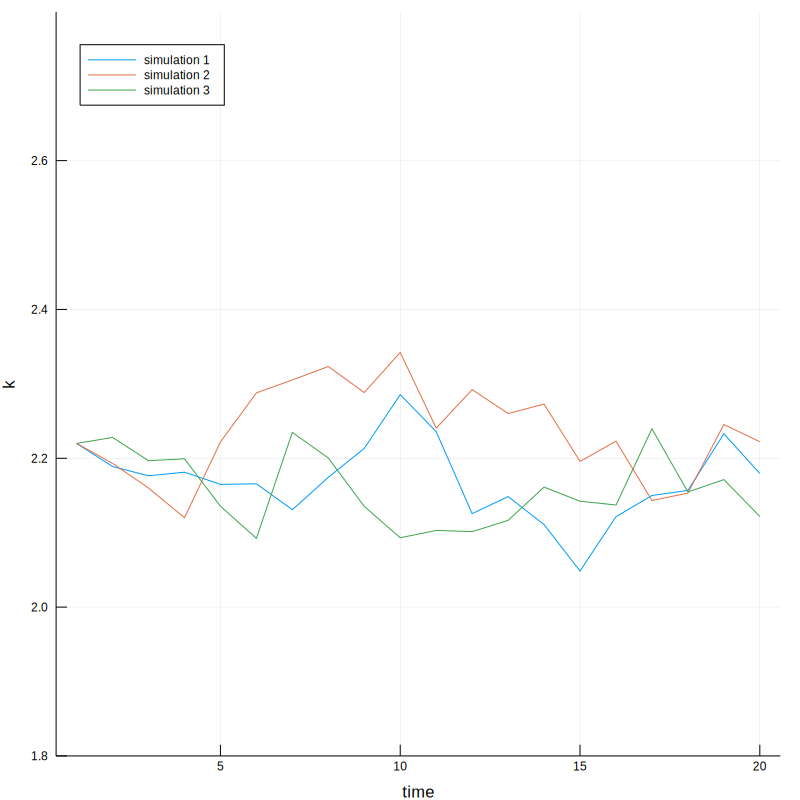

In [6]:
simulation_abc = zeros(20,3)
for i in 1:3 simulation_abc[:,i] = solow_swan(20, 0.02, 0.2, 0.1, 0.36, 2.22, 0.2, 1, 0)[1][1] end

plot(1:20, simulation_abc, ylims=(1.8,2.8), legend=:topleft,
    label = ["simulation 1", "simulation 2", "simulation 3"], ylabel="k", xlabel="time")

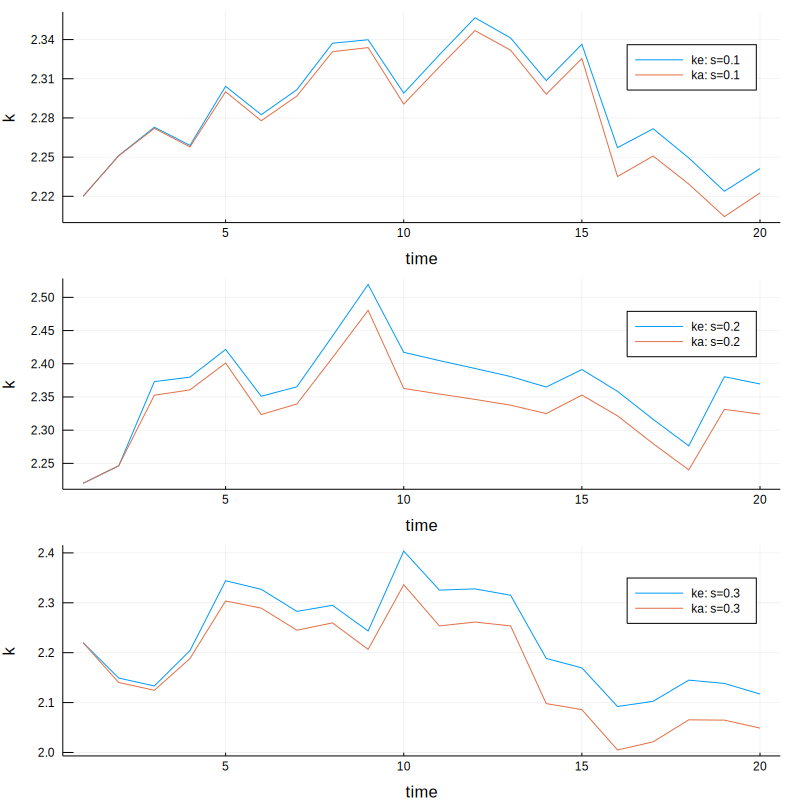

In [8]:
ks_e_a_levels = zeros(20,6); s_levels = [0.1, 0.2, 0.3]; 
labels = repeat(["ke: s=", "ka: s="], 1, 3).*string.(repeat(s_levels, 1, 2)')

for i in 1:3 
    temp_similation = solow_swan(20, 0.02, 0.2, 0.1, 0.36, 2.22, s_levels[i], 1, 0)
    ks_e_a_levels[:,i] = temp_similation[1][1]
    ks_e_a_levels[:,i+3] = temp_similation[2][1]
    
end
gr(size=(800,800))
plot(ks_e_a_levels, layout=@layout([a; b; c]), label = labels, ylabel="k", xlabel="time")

<br>

# Part 2

In [10]:
fred_data = Fred(); gr(size=(800,400));

API key loaded.


In [11]:
function get_yearly(year_init, year_final, code);
    data = get_data(fred_data, code).data
    output = []
    cache = [string.(1900:(year_init-1)); string.((year_final+1):2018)]
    counter = 1
    for i in 1:length(data.date)
        if string(data.date[i])[1:4] ∉ cache
            push!(output,data.value[i])
            counter += 1 
            push!(cache ,string(data.date[i])[1:4])
        end
    end
    return output
end

get_yearly (generic function with 1 method)

In [12]:
yₕ = get_yearly(1950, 2014, "A939RX0Q048SBEA")
Nₕ = get_yearly(1950, 2014, "CLF16OV")
Kₕ = get_yearly(1950, 2014, "RKNANPUSA666NRUG")
kₕ = Kₕ./Nₕ; k₀ = kₕ[1]
λₕ = log.(yₕ[2:end])-log.(yₕ[1:end-1]);
tₕ = length(yₕ)
nₕ = prod(Nₕ[2:end]./Nₕ[1:end-1])^(1/(length(Nₕ)-1))-1
σₕ = mean(get_data(fred_data, "PSAVERT").data.value./100)
δₕ = 0.1
θₕ = mean(-get_data(fred_data, "LABSHPUSA156NRUG").data.value.+1)
sₕ = std(log.(yₕ[2:end])-log.(yₕ[1:end-1]), corrected=false)
Aₕ = yₕ./(kₕ.^θₕ); A₀ = Aₕ[1]
αₕ = mean(log.(Aₕ[2:end])-log.(Aₕ[1:end-1]))
αₕ = prod(Aₕ[2:end]./Aₕ[1:end-1])^(1/(length(Aₕ)-1))-1;

In [14]:
sₕ

0.0263823561094945

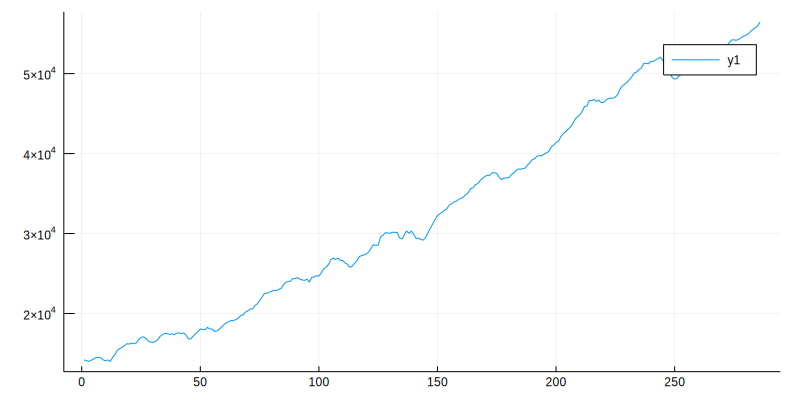

In [17]:
plot(1:286, get_data(fred_data, "A939RX0Q048SBEA").data.value)

<br>

# Part 3

In [9]:
exact_abc_c, approximation_abc_c, _, _= solow_swan(tₕ, 0.02, 0.2, 0.1, 0.36, 2.22, 0.2/2, 1, 0)
kₑ_abc_c, γₑ_abc_c, yₑ_abc_c, λₑ_abc_c = exact_abc_c
kₐ_abc_c, γₐ_abc_c, yₐ_abc_c, λₐ_abc_c = approximation_abc_c;

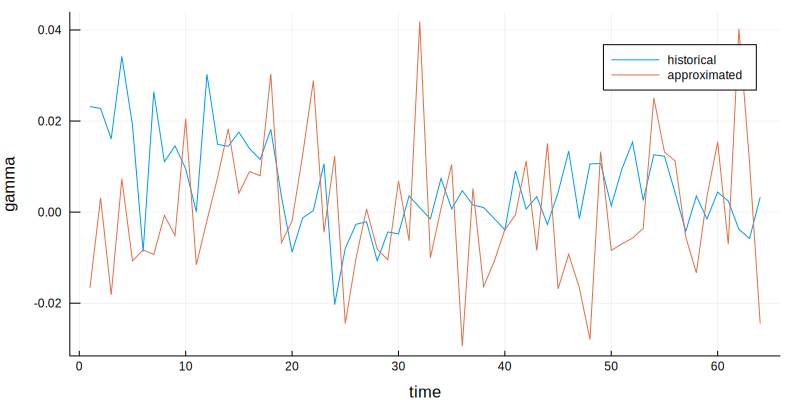

In [10]:
plot(1:tₕ-1, [(log.(kₕ[2:end])-log.(kₕ[1:end-1])).-mean(std(log.(kₕ[2:end])-log.(kₕ[1:end-1]))) γₐ_abc_c], 
    xlabel="time", ylabel="gamma",  label = ["historical", "approximated"])

<br>

# Part 4

In [78]:
exact_growth, approximation_growth, TFP_growth, nov = solow_swan(tₕ, nₕ, σₕ, δₕ, θₕ, k₀, sₕ/1.5, A₀, αₕ)
kₑ_growth, γₑ_growth, yₑ_growth, λₑ_growth = exact_growth
kₐ_growth, γₐ_growth, yₐ_growth, λₐ_growth = approximation_growth;

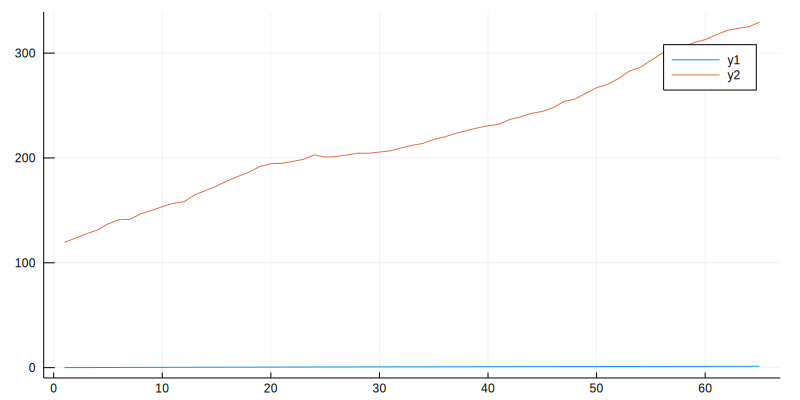

In [79]:
plot(1:tₕ, [nov[:,2] kₕ])

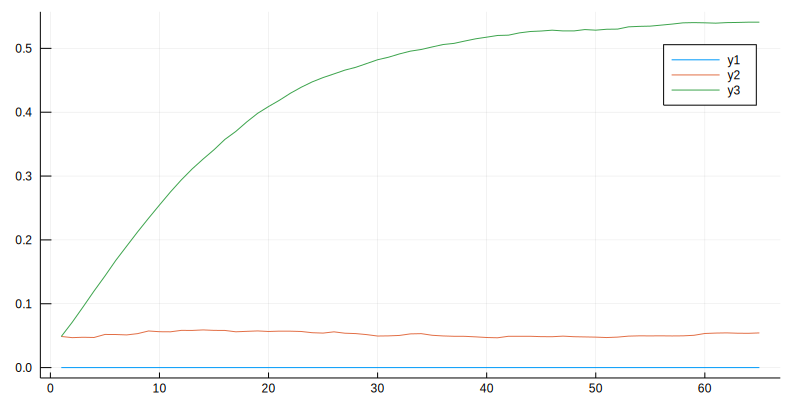

In [80]:
plot(1:tₕ, [zeros(tₕ) kₕ./Aₕ nov[:,1]])

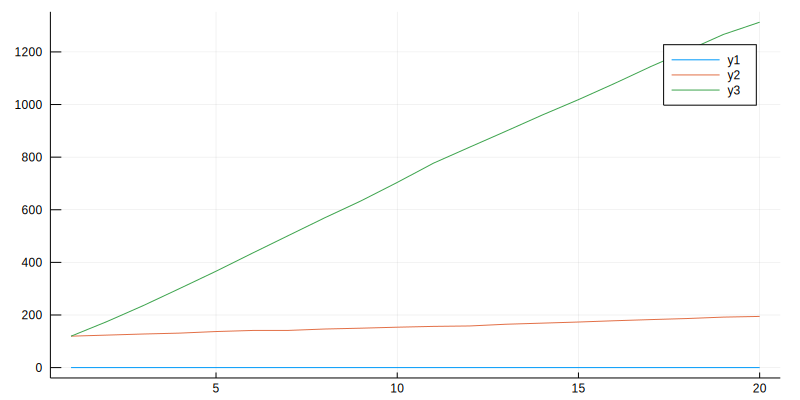

In [59]:
plot(1:20, [zeros(tₕ) kₕ nov[:,2]][1:20,:])

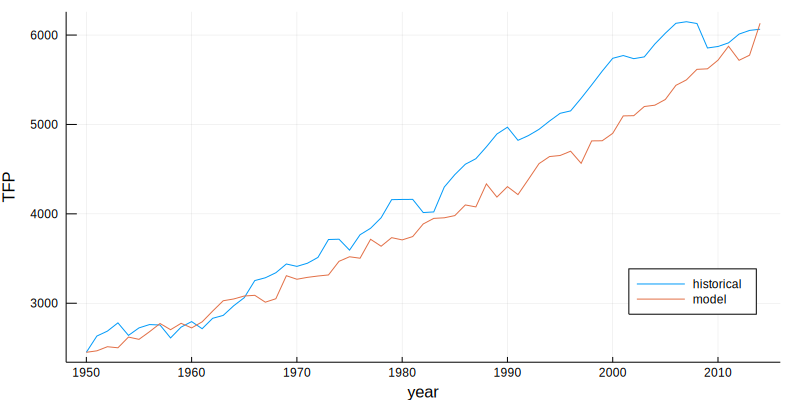

In [12]:
plot((1:tₕ).+1949, [Aₕ TFP_growth], label = ["historical", "model "], 
    legend=:bottomright, ylabel="TFP", xlabel="year")

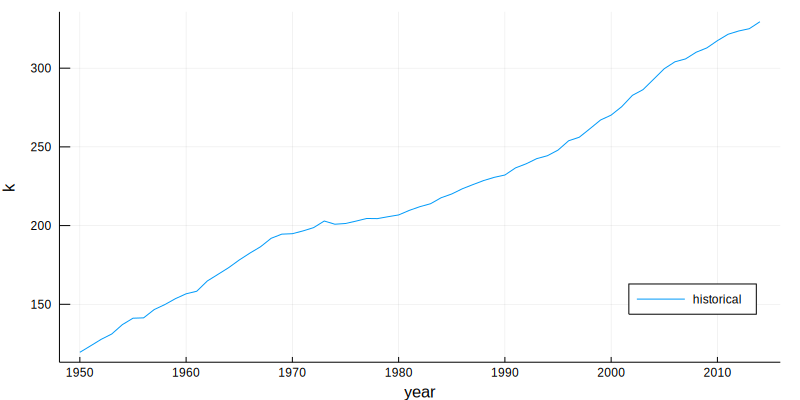

In [17]:
plot((1:tₕ).+1949, [kₕ], label = ["historical", "exact", "approximation"], 
    legend=:bottomright, ylabel="k", xlabel="year")

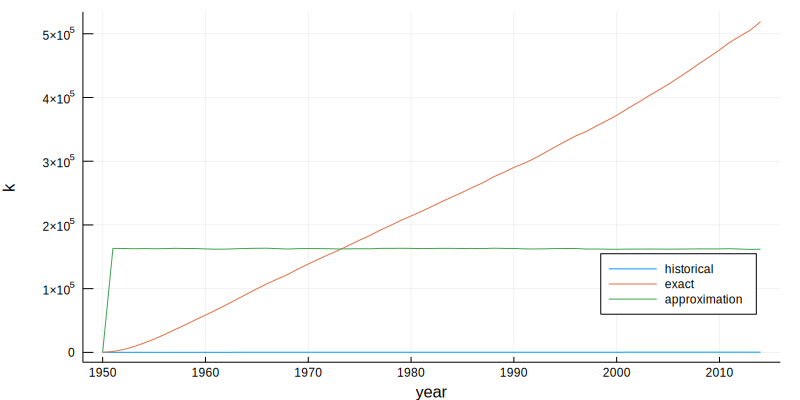

In [13]:
plot((1:tₕ).+1949, [kₕ kₑ_growth kₐ_growth], label = ["historical", "exact", "approximation"], 
    legend=:bottomright, ylabel="k", xlabel="year")

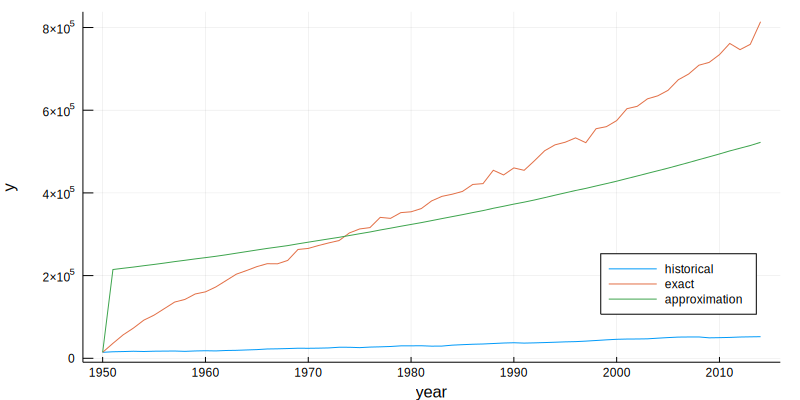

In [14]:
plot((1:tₕ).+1949, [yₕ yₑ_growth yₐ_growth], label = ["historical", "exact", "approximation"], 
    legend=:bottomright, ylabel="y", xlabel="year")

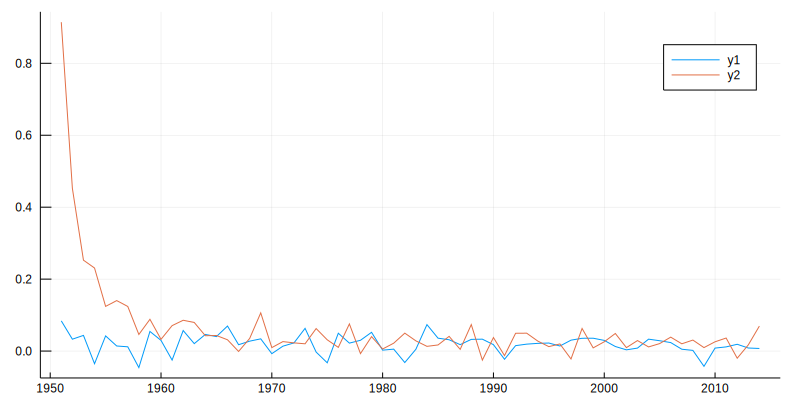

In [15]:
plot((1:tₕ-1).+1950, [log.(yₕ[2:end])-log.(yₕ[1:end-1]) log.(yₑ_growth[2:end])-log.(yₑ_growth[1:end-1])])

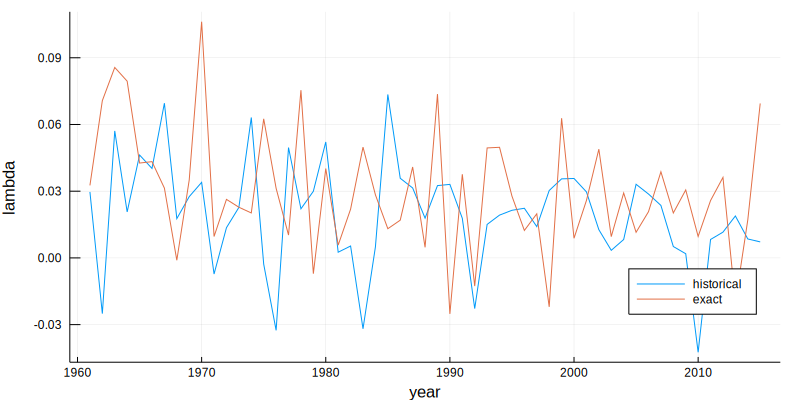

In [16]:
plot((1:tₕ-10).+1960, [λₕ[10:end] yₑ_growth[10:end]], label = ["historical", "exact"],
    legend=:bottomright,  ylabel="lambda", xlabel="year")

<br>